 **Outlier detection in gene expression data for Cancer patients using Local Outlier Factor (basic)** 

Dataset Used:[Gene Expression Cancer RNA-Seq Data Set ](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq)
 
Source: UCI Repository
 
**Sci-kit libraries have only been used for Data Visualisation. No in-built libraries have been used for the implementation of DBSCAN Algorithm, the code is purely for understanding the algorithmic logic.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

#to avoid getting a warning when making certain changes like coloumn renaming in a slice from a dataset
pd.options.mode.chained_assignment = None 

In [ ]:
dataset=pd.read_csv('/content/drive/My Drive/Datasets/data.csv')
dataset.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29,gene_30,gene_31,gene_32,gene_33,gene_34,gene_35,gene_36,gene_37,gene_38,...,gene_20491,gene_20492,gene_20493,gene_20494,gene_20495,gene_20496,gene_20497,gene_20498,gene_20499,gene_20500,gene_20501,gene_20502,gene_20503,gene_20504,gene_20505,gene_20506,gene_20507,gene_20508,gene_20509,gene_20510,gene_20511,gene_20512,gene_20513,gene_20514,gene_20515,gene_20516,gene_20517,gene_20518,gene_20519,gene_20520,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,0.591871,1.334282,2.015391,0.591871,0.0,0.0,0.0,0.0,0.591871,5.619994,1.334282,0.000000,9.796088,0.0,0.000000,1.598651,7.215116,10.839070,6.620204,9.513538,0.0,4.063658,7.764805,4.747656,13.714396,10.034496,0.000000,0.0,9.833458,...,9.370304,10.362393,5.589928,8.141964,0.000000,2.736583,7.037152,7.123480,10.967399,5.902800,3.719370,7.203554,6.042557,2.602077,7.425526,7.846957,2.824951,6.239396,0.000000,8.469593,0.0,6.535978,6.968701,7.128881,7.175175,9.249369,7.025970,8.045563,7.475709,7.205236,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,0.000000,0.587845,2.466601,1.004394,0.0,0.0,0.0,0.0,0.000000,11.055208,3.562621,0.000000,10.070470,0.0,0.000000,0.000000,9.949812,8.522476,1.174790,4.926991,0.0,0.000000,5.819832,1.327170,13.286240,6.663316,0.587845,0.0,9.533302,...,8.882967,9.898199,7.069401,7.186134,0.000000,3.134993,6.648930,6.715701,9.536238,1.004394,5.555482,8.029260,6.366219,0.811142,7.991732,7.161001,0.000000,4.708877,0.811142,8.451689,0.0,7.242336,8.046284,6.047558,8.572901,7.549030,7.019935,9.458940,9.190867,10.639259,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,0.000000,0.452595,1.981122,1.074163,0.0,0.0,0.0,0.0,1.683023,8.210248,4.195285,3.660427,8.970920,0.0,0.000000,0.796598,6.096650,9.861616,7.680507,3.119439,0.0,0.452595,7.899526,0.000000,10.731098,6.967883,0.452595,0.0,9.646323,...,10.355637,10.423274,5.170201,6.194260,0.000000,3.677147,6.271990,7.089816,9.675220,0.000000,4.224017,8.020402,6.967883,5.014445,8.400038,7.527555,0.000000,4.997902,0.796598,7.761132,0.0,6.820460,8.048983,6.661493,7.716332,6.745802,7.524667,8.602350,9.036654,10.336027,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,0.000000,0.434882,2.874246,0.000000,0.0,0.0,0.0,0.0,1.267356,8.306317,3.573556,0.000000,8.524616,0.0,0.000000,0.000000,3.913761,9.511573,6.469165,7.029895,0.0,1.267356,6.800641,7.742714,12.659474,8.299890,0.768587,0.0,9.670731,...,10.074382,9.918261,7.117924,7.196145,0.434882,3.609755,8.896696,7.577096,10.731446,5.075383,2.175652,7.675435,6.840816,6.233192,8.899886,8.319085,1.791814,5.661134,1.464093,8.625727,0.0,7.420095,7.784746,7.613915,8.963286,7.744699,7.924997,8.981473,8.665592,9.194823,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,0.000000,1.275841,2.141204,0.000000,0.0,0.0,0.0,0.0,0.889707,10.149150,2.967630,0.000000,8.047238,0.0,1.435949,0.000000,1.942120,8.821535,5.861429,7.755709,0.0,0.649386,5.570241,2.612801,13.556734,8.004754,0.000000,0.0,9.587569,...,10.129154,10.062303,6.911620,7.855149,0.360982,3.655810,7.255520,7.292607,10.779793,3.954001,6.991148,8.153248,7.508444,4.586531,9.152227,8.227717,0.360982,6.227104,0.649386,8.151879,0.0,6.558289,8.673708,6.505099,8.948989,7.010366,7.364056,8.950646,8.233366,9

In [ ]:
labels=pd.read_csv('/content/drive/My Drive/Datasets/labels.csv')
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [ ]:
labels=labels[labels.Class=='BRCA'].reset_index()
samples=labels['Unnamed: 0']
samples

0        sample_4
1        sample_8
2       sample_10
3       sample_13
4       sample_14
          ...    
295    sample_790
296    sample_791
297    sample_792
298    sample_793
299    sample_796
Name: Unnamed: 0, Length: 300, dtype: object

In [ ]:
merged=pd.merge(samples, dataset, how='inner', on=['Unnamed: 0'])
merged.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29,gene_30,gene_31,gene_32,gene_33,gene_34,gene_35,gene_36,gene_37,gene_38,...,gene_20491,gene_20492,gene_20493,gene_20494,gene_20495,gene_20496,gene_20497,gene_20498,gene_20499,gene_20500,gene_20501,gene_20502,gene_20503,gene_20504,gene_20505,gene_20506,gene_20507,gene_20508,gene_20509,gene_20510,gene_20511,gene_20512,gene_20513,gene_20514,gene_20515,gene_20516,gene_20517,gene_20518,gene_20519,gene_20520,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.000000,0.000000,1.275841,2.141204,0.000000,0.0,0.0,0.0,0.0,0.889707,10.149150,2.967630,0.000000,8.047238,0.0,1.435949,0.0,1.942120,8.821535,5.861429,7.755709,0.0,0.649386,5.570241,2.612801,13.556734,8.004754,0.000000,0.0,9.587569,...,10.129154,10.062303,6.911620,7.855149,0.360982,3.655810,7.255520,7.292607,10.779793,3.954001,6.991148,8.153248,7.508444,4.586531,9.152227,8.227717,0.360982,6.227104,0.649386,8.151879,0.0,6.558289,8.673708,6.505099,8.948989,7.010366,7.364056,8.950646,8.233366,9.298775,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
1,sample_8,0.0,3.992125,2.772730,6.546692,10.488252,0.0,7.690222,0.352307,0.0,4.067604,1.411318,1.252839,2.579977,0.000000,0.0,0.0,0.0,0.0,0.635336,10.147625,4.287908,4.773828,8.343976,0.0,0.000000,0.0,6.080374,7.600537,2.824931,4.934233,0.0,0.000000,5.244617,9.464329,13.531004,5.944411,0.000000,0.0,8.542196,...,11.350210,10.845960,6.599748,7.967163,0.000000,7.629808,8.682851,7.812396,9.555722,1.554049,6.406288,8.114591,7.416570,3.082175,9.394889,7.888506,0.635336,6.865783,1.252839,7.504906,0.0,6.501863,8.488764,4.308193,8.290171,8.069799,7.987747,9.469967,9.595914,10.461326,6.721974,9.597533,9.763753,7.933278,10.952880,12.498919,10.389954,10.390255,7.828321,0.000000
2,sample_10,0.0,3.492071,3.553373,7.151707,10.253446,0.0,8.301258,0.000000,0.0,0.000000,0.000000,1.999567,3.381962,0.000000,0.0,0.0,0.0,0.0,1.651683,7.965224,2.146395,0.000000,8.115408,0.0,0.000000,0.0,3.920036,9.540533,7.617298,8.353231,0.0,0.514400,7.342919,2.146395,13.927871,8.788738,0.892818,0.0,9.975074,...,10.318306,10.156905,6.744753,8.356989,0.000000,4.776462,7.100473,7.642261,11.114198,5.989750,5.814143,8.516543,6.973439,3.878617,8.245329,8.769038,0.514400,5.468218,1.192320,8.408826,0.0,7.623582,8.855641,8.187144,9.313613,7.949681,7.122818,8.954880,8.066681,9.404882,6.231006,9.061674,10.042261,6.580103,9.785004,12.383834,9.869359,8.991768,5.735121,0.892818
3,sample_13,0.0,1.551048,3.529846,6.326825,10.633849,0.0,8.944659,0.000000,0.0,0.000000,1.413648,0.501821,2.479282,1.168642,0.0,0.0,0.0,0.0,0.000000,8.526534,0.000000,0.000000,10.717848,0.0,0.000000,0.0,1.413648,11.250760,4.932496,8.156048,0.0,0.873420,7.041024,0.000000,12.882658,11.437622,0.501821,0.0,9.775964,...,9.318174,9.523638,2.583086,7.807258,0.501821,5.969328,5.772575,7.219991,10.512958,4.766012,5.585260,6.906806,6.444856,0.000000,7.809935,8.386488,0.000000,4.872292,0.501821,8.888777,0.0,7.150052,7.517394,6.797584,6.742599,9.209346,7.175185,7.804576,8.240710,11.119337,3.920732,7.846901,9.379835,7.195800,8.907645,12.079481,9.218936,8.104101,3.660894,0.000000
4,sample_14,0.0,1.964842,2.183010,6.596832,10.248141,0.0,7.087251,0.441483,0.0,0.000000,0.000000,0.000000,2.896214,1.480369,0.0,0.0,0.0,0.0,0.000000,7.993499,2.750306,4.240459,9.580091,0.0,0.000000,0.0,0.441483,9.030720,7.468868,8.245191,0.0,0.441483,5.618142,0.000000,11.795273,8.184930,0.000000,0.0,10.078418,...,9.999380,10.024239,7.331302,8.447137,0.000000,5.869945,5.705961,6.671859,10.001394,4.003386,5.792382,7.696759,7.492005,2.587965,8.866682,8.089546,1.282262,6.892318,2.405039,8.391308,0.0,6.956115,8.206072,5.942712,9.300195,8.26703

In [ ]:
#For simplicity let's consider the gene expression of only 2 genes- gene_1 and gene_2
df=merged[['Unnamed: 0','gene_1','gene_2']]
df.head()

,Unnamed: 0,gene_1,gene_2
0,sample_4,2.655741,2.821547
1,sample_8,3.992125,2.772730
2,sample_10,3.492071,3.553373
3,sample_13,1.551048,3.529846
4,sample_14,1.964842,2.183010


In [ ]:
#Rename the unnamed coloumn in df to access it easily
df.rename(columns = {'Unnamed: 0': 'sample_no'}, inplace = True)
df.head()

,sample_no,gene_1,gene_2
0,sample_4,2.655741,2.821547
1,sample_8,3.992125,2.772730
2,sample_10,3.492071,3.553373
3,sample_13,1.551048,3.529846
4,sample_14,1.964842,2.183010


In [ ]:
#assigning shorter symbols to easily access them
x=df['gene_1']
y=df['gene_2']
k=17
#current shape of our dataframe
df.shape

(300, 3)

In [ ]:
#Test & understand with smaller numbers,change the df accessing codes to run this
#x=[0,0,1,3]
#y=[0,1,1,0]

In [ ]:
#lrd: Local Reachability Distance
#rd: Reachability Distance
#lof:Local outlier factor
#nk: Neighbours in k-neighbourhood

temp=[] #temporary list
lrd=[] #store lrd values for all points
rd=[] #store a matrix of rd values[ rd(A,B) != rd(B,A) ]
lof=[]  #store rd values of all points
nk=[] #store k neighbours of each point
nk_dist=[] #store distances of k neighbours from a point
outlier=[] #store indices of outliers

#Note: The value of threshold has been randomly set. 
#Domain knowledge is needed for correct estimation.
threshold=1.5 # a value of lof score greater than 1 beyond which point is outlier

#iterate create the lists and matrices
for i in range(len(x)):
  for j in range(len(y)):
    temp.append(0)
  lrd.append(0)
  lof.append(-1) #lof can never be -1
  nk.append(0)
  nk_dist.append(0)
  rd.append(temp)
  temp=[]

In [ ]:
def find_nk(i,x,k,flag):

  #i is the index of point
  #x,y - attributes of dataframe
  #flag=0 means knn are being calculated for current point,
  #flag=1 means knn are being calculated for current point's neighbour
  #kdist value can be accessed anywhere all over the code
  global kdist

  #temporary dictionary to store neighbours and their distances
  #key:index if point,value: distance
  d=dict()

  #neigh:set of k neighbours
  #neigh_dist: distance of all the corresponding k neighbours from i
  neigh=[]
  neigh_dist=[]
  
  #print('Point',i,':',(x[i],y[i]))
  for j in range(len(x)):
    #Finding out the neighbours for each point 'i' in the dataframe
    if i==j:   #when element taken with itself 
      continue 
    else:
      #distance of jth point from i
      #manhattan distance has been used
      dist=abs(x.iloc[i]-x.iloc[j]) + abs(y.iloc[i]- y.iloc[j])
      d[j]=dist
      #print('Dist from point',j,':',(x[j],y[j]),'=',dist)

  #Sorting by value in ascending order-> sorting by distance
  d={u:v for u,v in sorted(d.items(), key=lambda item:item[1],reverse=False)}
  j=1

  #iterate in d to pick out k neighbours 
  for u,v in d.items():
    #points in k- neighbourhood only taken
    if j>k and v!= kdist:
      break

    #when kth neighbour reached for flag=0
    if j==k and flag==0:
      #update the kdist
      kdist=v
      #print('k distance =',kdist)
    #store the k neighbours in the lists
    neigh_dist.append(v)
    neigh.append(u)
    j=j+1

  #print('K nearest neighbours are: ',neigh)
  #print('Distances of the K neighbours: ',neigh_dist)
  return neigh,neigh_dist


In [ ]:
def update_rd(i):
  
  c=0 #counter to iterate through neigh_dist
  #rdsum is the sum of rd of a given point wrt to its neighbours
  global rdsum
  #initialise to zero initially
  rdsum=0

  #for all neighbours, calculate rd to given point
  for j in nk[i]:
    rd[j][i]=max(kdist,nk_dist[i][c])  #rd from k to i(i is the point under question)
    #print('In terms of indices:\nRD(',j,',',i,') =',rd[j][i])
    rdsum=rdsum + rd[j][i]
    c=c+1
  #print('Sum of RD for point',i,'=',rdsum)

In [ ]:
def calc_lrd(i,rdsum):
  #update lrd for every point
  lrd[i]=1/(rdsum/len(nk[i]))
  #print('LRD for point',i,'=',lrd[i])

In [ ]:
def calc_lof(i):
  #calculate the lof score for every point
  lrdsum=0
  for j in nk[i]:
    #sum of lrd of all k neighbours used
    lrdsum=lrdsum+lrd[j]
  lof[i]=(lrdsum / lrd[i])/len(nk[i])
#  print('LOF Score for point',i,'=',lof[i])


In [ ]:
for i in range(len(x)):
  if nk[i]==0:
    nk[i],nk_dist[i]=find_nk(i,x,k,0)
  update_rd(i)
  calc_lrd(i,rdsum)
  #print('\n')
  
for i in range(len(x)):
  calc_lof(i)

In [ ]:
outlier_x=[]
outlier_y=[]
non_outlier_x=[]
non_outlier_y=[]
for i in range(len(lof)):
  if lof[i]>threshold:
    outlier.append(i)
    outlier_x.append(x.iloc[i])
    outlier_y.append(y.iloc[i])
  else:
    non_outlier_x.append(x.iloc[i])
    non_outlier_y.append(y.iloc[i])

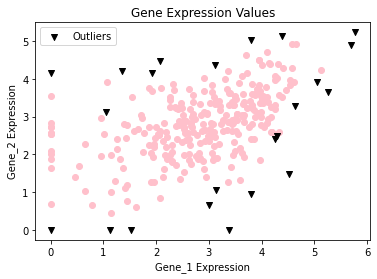

In [ ]:
plt.scatter(non_outlier_x,non_outlier_y,c='pink')
plt.scatter(outlier_x,outlier_y,c='#000000',marker='v',label='Outliers') 
plt.xlabel('Gene_1 Expression')
plt.ylabel('Gene_2 Expression')
plt.title('Gene Expression Values')
plt.legend()
plt.show()

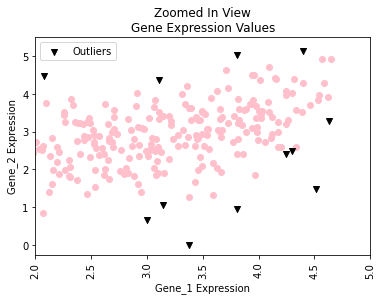

In [ ]:
#Zoomed in on x=2 to x=5
plt.scatter(non_outlier_x,non_outlier_y,c='pink')
plt.scatter(outlier_x,outlier_y,c='#000000',marker='v',label='Outliers') 
plt.xlabel('Gene_1 Expression')
plt.ylabel('Gene_2 Expression')
plt.title('Zoomed In View\nGene Expression Values')
plt.xlim(2,5)
plt.xticks(rotation=90)
plt.legend()
plt.show()